In [2]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
import constants as c

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [3]:
synthfirm_all = read_csv('outputs/synthetic_firms.csv')
sf_map = gpd.read_file('inputs/Austin_freight.geojson')
mesozone_id_lookup = read_csv('inputs/zonal_id_lookup_final.csv')

lehd_validation = read_csv('inputs/LEHD_employment.csv')
sf_map.head(5)

/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_50061/3523137233.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  synthfirm_all = read_csv('outputs/synthetic_firms.csv')


,GEOID,CBPZONE,MESOZONE,geometry
0,483030018015,48303,4058.0,"MULTIPOLYGON (((-101.92240 33.55329, -101.9137..."
1,480291812003,48029,1188.0,"MULTIPOLYGON (((-98.53937 29.53751, -98.53230 ..."
2,481279502001,48127,2439.0,"MULTIPOLYGON (((-100.11434 28.64812, -100.0004..."
3,480291906041,48029,1367.0,"MULTIPOLYGON (((-98.52411 29.48090, -98.51597 ..."
4,480291715023,48029,1032.0,"MULTIPOLYGON (((-98.58195 29.42276, -98.58184 ..."


In [4]:
print(synthfirm_all.columns)
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())

Index(['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE'],
      dtype='object')
firm_count          8.390414e+06
employment_count    1.061455e+08
dtype: float64


In [5]:
print(mesozone_id_lookup.columns)
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['Unnamed: 0', 'GEOID', 'CBPZONE', 'MESOZONE', 'FAFID', 'FAFNAME'], dtype='object')


,MESOZONE,firm_count,employment_count,Unnamed: 0,GEOID,CBPZONE,FAFID,FAFNAME
0,1,25,167.856230,6796,480019501001,48001,489,Rest of TX
1,2,27,312.283632,3452,480019501002,48001,489,Rest of TX
2,3,22,182.085546,2359,480019501003,48001,489,Rest of TX
3,4,27,195.861892,3732,480019504011,48001,489,Rest of TX
4,5,27,144.684876,3068,480019504021,48001,489,Rest of TX


In [16]:
firm_in_study_area = firm_by_zone.loc[firm_by_zone['FAFID'].isin([481, 488, 489])]
print(firm_in_study_area.firm_count.sum())
# sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
# sf_map_with_firm.head(5)
synthfirm_in_study_area = synthfirm_all.loc[synthfirm_all['MESOZONE'] < 20000]
print(synthfirm_in_study_area.Emp.sum())
print(len(synthfirm_all.Industry_NAICS6_Make.unique()))
print(len(synthfirm_in_study_area.Industry_NAICS6_Make.unique()))
synthfirm_in_study_area.head(5)

257263
3144499.5644305707
410
400


,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE
1015,1,48061,489,1111A0,3,3.936988,1016,1946
1016,1,48119,489,1111A0,3,3.936988,1017,2415
1017,1,48279,489,1111A0,3,3.936988,1018,3838
1071,1,48453,481,1111A0,3,3.936988,1072,5665
1075,1,48115,489,1111A0,3,3.936988,1076,2388


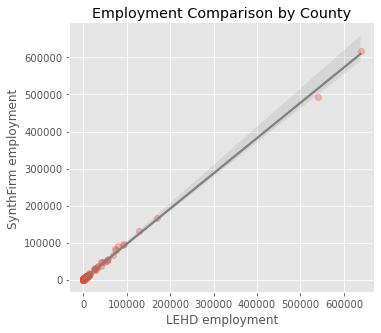

In [25]:
# compare to LEHD data
#lehd_validation.head(5)
lehd_firm_by_county = lehd_validation.loc[lehd_validation['industry'] == '0']
firm_in_study_area_by_county = firm_in_study_area.groupby('CBPZONE')[['employment_count']].sum()
firm_in_study_area_by_county = firm_in_study_area_by_county.reset_index()
# print(firm_in_study_area_by_county.head(5))

lehd_firm_by_county = lehd_firm_by_county.groupby('geography')[['EmpS']].mean()
lehd_firm_by_county = lehd_firm_by_county.reset_index()
# print(lehd_firm_by_county.head(5))
firm_comparison_by_county = pd.merge(lehd_firm_by_county, 
                                     firm_in_study_area_by_county,
                                     left_on = 'geography',
                                     right_on = 'CBPZONE',
                                     how = 'inner')
firm_comparison_by_county.columns = ['County', 'LEHD employment', 'CBPZONE', 'SynthFirm employment']

firm_comparison_by_county.head(5)
plt.style.use('ggplot')
g = sns.lmplot(
    data=firm_comparison_by_county,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, scatter_kws = {'alpha':0.3})
plt.title('Employment Comparison by County')
plt.savefig('plots/austin_emp_by_county_validation.png', dpi = 200,
           bbox_inches = 'tight')

['11' '21' '22' '23' '31-33' '42' '44-45' '48-49' '51' '52' '53' '54' '55'
 '56' '61' '62' '71' '72' '81' '92']


/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_50061/509628476.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_50061/509628476.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthfirm_in_study_area.loc[:, 'industry'] = synthfirm_in_study_area.loc[:, 'NAICS2'].map(industry_lookup)


  Industry  LEHD employment  SynthFirm employment
0       11     38584.750000          47249.741151
1       21     83773.166667          65961.123234
2       22     15279.250000          15724.570686
3       23    199091.500000           5576.446112
4    31-33    266384.583333         219156.174496


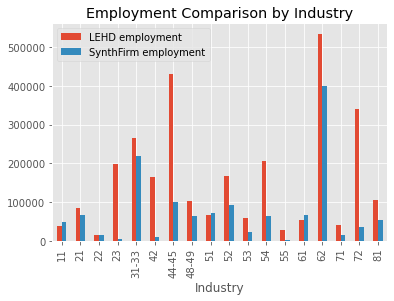

In [24]:
# compare to LEHD data
#lehd_validation.head(5)
industry_lookup = {'11':'11', '21':'21', '22':'22', '23':'23',
                   '31':'31-33', '32':'31-33', '33':'31-33',
                   '42':'42', '44':'44-45', '45':'44-45',
                   '48':'48-49', '49':'48-49', '51':'51',
                   '52':'52', '53':'53', '54':'54', '55':'55',
                   '56':'56', '61':'61', '62':'62', '71':'71',
                   '72':'72', '81':'81', '92':'92'}
selected_counties = firm_comparison_by_county.County.unique()
lehd_firm_by_industry = lehd_validation.loc[lehd_validation['industry'] != '0']

print(lehd_firm_by_industry.industry.unique())

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['geography', 'industry'])[['EmpS']].mean()

lehd_firm_by_industry = lehd_firm_by_industry.reset_index()
lehd_firm_by_industry = \
lehd_firm_by_industry.loc[lehd_firm_by_industry['geography'].isin(selected_counties)]

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['industry'])[['EmpS']].sum()

synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
synthfirm_in_study_area.loc[:, 'industry'] = synthfirm_in_study_area.loc[:, 'NAICS2'].map(industry_lookup)

firm_in_study_area_by_industry = synthfirm_in_study_area.groupby(['industry'])[['Emp']].sum()
firm_in_study_area_by_industry = firm_in_study_area_by_industry.reset_index()
firm_comparison_by_industry = pd.merge(lehd_firm_by_industry,
                                       firm_in_study_area_by_industry,
                                       on = 'industry', how = 'inner')

firm_comparison_by_industry.columns = ['Industry', 'LEHD employment',  'SynthFirm employment']

print(firm_comparison_by_industry.head(5))
plt.style.use('ggplot')
firm_comparison_by_industry.plot(kind = 'bar',
    x="Industry")
plt.title('Employment Comparison by Industry')
plt.savefig('plots/austin_emp_by_industry_validation.png', dpi = 200)

In [11]:
firm_in_austin = firm_by_zone.loc[firm_by_zone['FAFID'].isin([481, 488, 489])]
sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
sf_map_with_firm.head(5)

,GEOID_x,CBPZONE_x,MESOZONE,geometry,firm_count,employment_count,Unnamed: 0,GEOID_y,CBPZONE_y,FAFID,FAFNAME
0,483030018015,48303,4058.0,"MULTIPOLYGON (((-101.92240 33.55329, -101.9137...",32,345.834705,0,483030018015,48303,489,Rest of TX
1,480291812003,48029,1188.0,"MULTIPOLYGON (((-98.53937 29.53751, -98.53230 ...",37,1468.036464,1,480291812003,48029,488,San Antonio
2,481279502001,48127,2439.0,"MULTIPOLYGON (((-100.11434 28.64812, -100.0004...",47,330.584676,2,481279502001,48127,489,Rest of TX
3,480291906041,48029,1367.0,"MULTIPOLYGON (((-98.52411 29.48090, -98.51597 ...",32,231.116608,3,480291906041,48029,488,San Antonio
4,480291715023,48029,1032.0,"MULTIPOLYGON (((-98.58195 29.42276, -98.58184 ...",38,448.181566,4,480291715023,48029,488,San Antonio


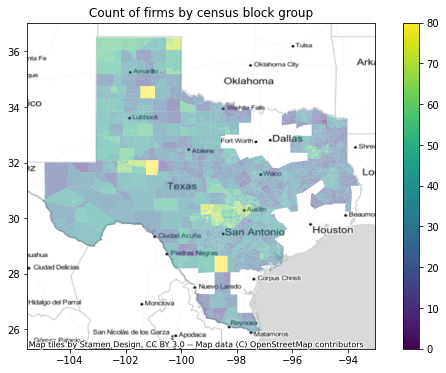

In [17]:
ax = sf_map_with_firm.plot(figsize = (10,6), column = 'firm_count', 
                           vmin=0, vmax=80, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.Stamen.TonerLite)
plt.title('Count of firms by census block group')
plt.savefig('plots/austin_region_firm_count.png', dpi = 200)

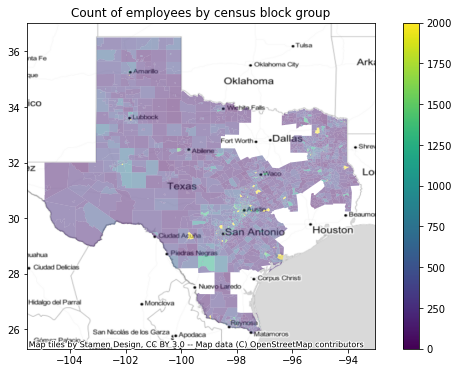

In [19]:
ax = sf_map_with_firm.plot(figsize = (10,6), column = 'employment_count', 
                            vmin=0, vmax=2000, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.Stamen.TonerLite)
plt.title('Count of employees by census block group')
plt.savefig('plots/austin_region_emp_count.png', dpi = 200)

In [24]:
combined_modeled_OD = None

for sctg in c.list_of_sctg_group:
    print(sctg)
    b2b_dir = c.output_dir + sctg
    list_of_b2b_files = os.listdir(b2b_dir)
    iterator = 0
#     cut_off_point = max_ton_lookup[sctg] # shipment capacity for this shipment
    for file in list_of_b2b_files:
        if file == '.DS_Store':
            continue
        if iterator%10 == 0:
            print(iterator)
        modeled_OD_by_sctg = read_csv(b2b_dir + '/' + file, sep = ',', low_memory = False)
        modeled_OD_by_sctg['ShipmentLoad'] = modeled_OD_by_sctg['TruckLoad'] / 1000 # convert to thousand tons
        
        #print(cut_off_point)
#         modeled_OD_by_sctg.loc[modeled_OD_by_sctg['ShipmentLoad'] > cut_off_point, 'ShipmentLoad'] = cut_off_point
        modeled_OD_by_sctg['tmiles'] = modeled_OD_by_sctg['ShipmentLoad'] * 1000 * modeled_OD_by_sctg['Distance']
        modeled_OD_by_sctg = pd.merge(modeled_OD_by_sctg, mesozone_id_lookup, 
                                      left_on = ['SellerZone', 'orig_FAFID'], 
                                    right_on = ['MESOZONE', 'FAFID'], how = 'left')
        modeled_OD_by_sctg = modeled_OD_by_sctg.rename(columns={"GEOID": "orig_GEOID",
                                                                "CBPZONE": "orig_CBPZONE", 
                                                                "MESOZONE":"orig_MESOZONE", 
                                                                "FAFNAME":"orig_FAFNAME"})
        modeled_OD_by_sctg = pd.merge(modeled_OD_by_sctg, mesozone_id_lookup, 
                                      left_on = ['BuyerZone', 'dest_FAFID'], 
                                    right_on = ['MESOZONE', 'FAFID'], how = 'left')
        modeled_OD_by_sctg = modeled_OD_by_sctg.rename(columns={"GEOID": "dest_GEOID", 
                                                                "CBPZONE": "dest_CBPZONE", 
                                                                "MESOZONE":"dest_MESOZONE", 
                                                               "FAFNAME":"dest_FAFNAME"})    
        agg_OD_by_sctg = modeled_OD_by_sctg.groupby(["orig_FAFID", "orig_MESOZONE", "dest_FAFID", "dest_MESOZONE"])[['tmiles', 'ShipmentLoad']].sum()        
        agg_OD_by_sctg = agg_OD_by_sctg.reset_index()
        agg_count_by_sctg = modeled_OD_by_sctg.groupby(["orig_FAFID", "orig_MESOZONE", "dest_FAFID", "dest_MESOZONE"])[['shipment_id']].count() 
        agg_count_by_sctg = agg_count_by_sctg.reset_index()
        agg_OD_by_sctg = pd.merge(agg_OD_by_sctg, agg_count_by_sctg, 
                                  on = ["orig_FAFID", "orig_MESOZONE", "dest_FAFID", "dest_MESOZONE"],
                                  how = 'left')
        agg_OD_by_sctg = agg_OD_by_sctg.rename(columns={"shipment_id": "count"})
        agg_OD_by_sctg.loc[:, 'SCTG_Name'] = c.sctg_def[sctg]
        agg_OD_by_sctg.loc[:, 'chunk_id'] = iterator
        combined_modeled_OD = pd.concat([combined_modeled_OD, agg_OD_by_sctg], sort = False)
        iterator += 1 
#         break        
#     break
#     combined_truck_output.to_csv(c.input_dir + 'truck_only_OD_' + sctg + '.csv', index = False)
# combined_modeled_OD = pd.merge(combined_modeled_OD, sctg_group_definition, on = ['SCTG_Group'], how = 'left')
combined_modeled_OD.head(10)  

sctg1
0
10
sctg2
0
sctg3
0
10
20
30
sctg4
0
10
20
30
40
sctg5
0
10


,orig_FAFID,orig_MESOZONE,dest_FAFID,dest_MESOZONE,tmiles,ShipmentLoad,count,SCTG_Name,chunk_id
0,11,20001,64,4,68045.248008,0.027102,2,bulk,0
1,11,20001,64,5,27442.412632,0.013772,1,bulk,0
2,11,20001,64,6,3153.326894,0.001582,1,bulk,0
3,11,20001,64,7,19422.102522,0.009747,1,bulk,0
4,11,20001,64,8,28670.441800,0.010665,1,bulk,0
5,11,20001,64,12,2003.583060,0.001006,1,bulk,0
6,11,20001,64,13,57121.545289,0.028666,1,bulk,0
7,11,20001,64,14,35622.644200,0.013251,1,bulk,0
8,11,20001,64,15,60031.972000,0.022330,1,bulk,0
9,11,20001,64,16,188202.895556,0.080411,2,bulk,0


In [25]:
sf_origin_shipment = combined_modeled_OD.loc[combined_modeled_OD['orig_FAFID'] == 64]
sf_origin_shipment = sf_origin_shipment.groupby(['orig_MESOZONE'])[['ShipmentLoad']].sum()
sf_origin_shipment = sf_origin_shipment.reset_index()
sf_origin_shipment.columns = ['MESOZONE', 'Tonnage']
sf_origin_shipment.head(5)

,MESOZONE,Tonnage
0,1,9.011370
1,2,11.880804
2,3,1.192125
3,4,9.285994
4,5,6.660419


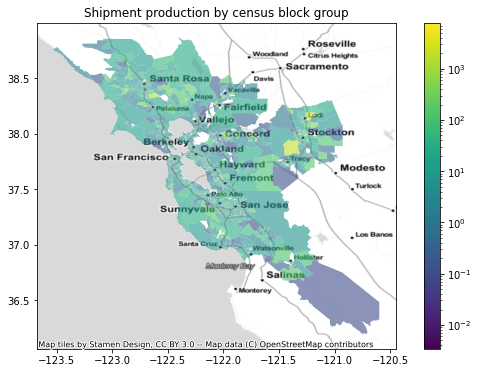

In [29]:
import matplotlib
sf_map_with_tonnage = sf_map.merge(sf_origin_shipment, on='MESOZONE', how='inner')
# sf_map_with_tonnage.head(5)
ax = sf_map_with_tonnage.plot(figsize = (10,6), column = 'Tonnage', alpha = 0.6, 
                               norm=matplotlib.colors.LogNorm(vmin=sf_map_with_tonnage.Tonnage.min(), vmax=sf_map_with_tonnage.Tonnage.max()),
                              legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.Stamen.TonerLite)
plt.title('Shipment production by census block group')
plt.savefig('Plot/sf_shipment_production.png', dpi = 200)
plt.show()